# 데이터 분석

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.font_manager as fm
from matplotlib import gridspec

from data_func import *

In [2]:
path = '../9.data/0.work_data/0.전처리 데이터/'
path_3d = '../9.data/0.work_data/9.3D 그래프/'
path_AL = '../9.data/0.work_data/3.Accident_list/'
path_h = "../9.data/0.work_data/2.heatmap/"

In [3]:
## v1 버전이 속도 0인데 교통량 존재하는 데이터들 삭제한 데이터

up_data_v1 = pd.read_csv(path + 'upline_data_v1.csv', encoding='utf-8')
down_data_v1 = pd.read_csv(path + 'downline_data_v1.csv', encoding='utf-8')

In [4]:
up_data_v1["datetime"] = up_data_v1["통계날짜"] + " " + up_data_v1["통계시각"]
up_data_v1["datetime"] = pd.to_datetime(up_data_v1["datetime"], format='%Y-%m-%d %H:%M:%S', errors='raise')
up_data_v1["요일"] = up_data_v1["datetime"].dt.weekday

down_data_v1["datetime"] = down_data_v1["통계날짜"] + " " + down_data_v1["통계시각"]
down_data_v1["datetime"] = pd.to_datetime(down_data_v1["datetime"], format='%Y-%m-%d %H:%M:%S', errors='raise')
down_data_v1["요일"] = down_data_v1["datetime"].dt.weekday

## 사고데이터 분류 및 생성

### 사고 히트맵 생성

In [5]:
# 사고 히트맵 생성
create_accident_heatmap(up_data_v1, "속도")
create_accident_heatmap(down_data_v1, "속도")

<Figure size 1512x864 with 0 Axes>

<Figure size 1512x864 with 0 Axes>

### 사고 리스트 생성(차이값 리스트)

In [38]:
# 사고 리스트 생성
upAccList = create_accident_list(up_data_v1, "속도")
downAccList = create_accident_list(down_data_v1, "속도")

<Figure size 1512x864 with 0 Axes>

In [39]:
for i in range(0, 612, 12):
    del downAccList[i]
downAccList = ((downAccList.T).reset_index(drop=True)).T

AccList = pd.concat([upAccList, downAccList], axis = 0)

In [43]:
AccList.to_csv(path_AL + "AccList.csv", header=False)

### 사고 리스트 생성(사고데이터 + 패턴데이터)

In [17]:
UpAccident, UpPattern = create_accident_pattern_list(up_data_v1, "속도")
DownAccident, DownPattern = create_accident_pattern_list(down_data_v1, "속도")

<Figure size 1512x864 with 0 Axes>

<Figure size 1512x864 with 0 Axes>

In [20]:
for i in range(0, 612, 12):
    del DownAccident[i]
DownAccident = ((DownAccident.T).reset_index(drop=True)).T

AccList_accident = pd.concat([UpAccident, DownAccident], axis = 0)

for i in range(0, 612, 12):
    del DownPattern[i]
DownPattern = ((DownPattern.T).reset_index(drop=True)).T

AccList_pattern = pd.concat([UpPattern, DownPattern], axis = 0)

In [21]:
AccList_accident.to_csv(path_AL + "AccList_accident.csv", header=False)
AccList_pattern.to_csv(path_AL + "AccList_pattern.csv", header=False)

## 3D 그래프, 등고선 그래프 생성

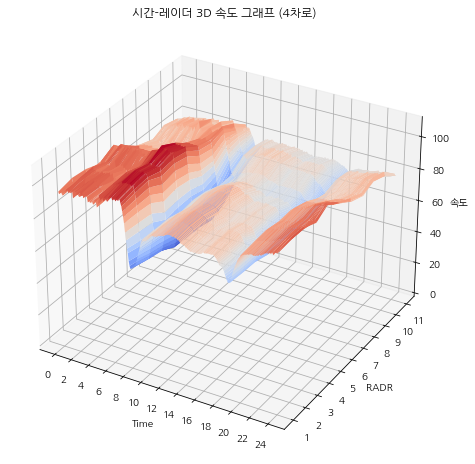

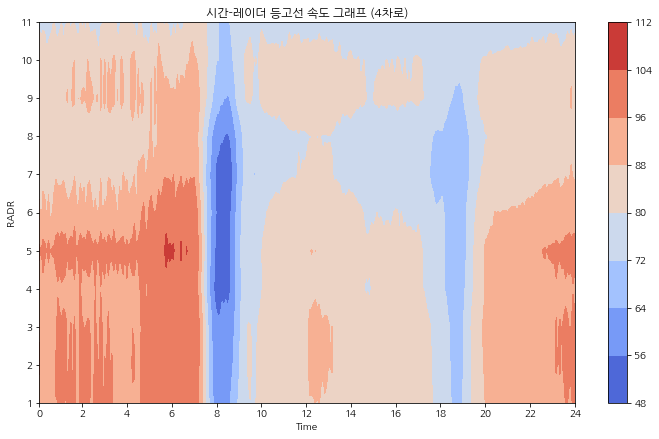

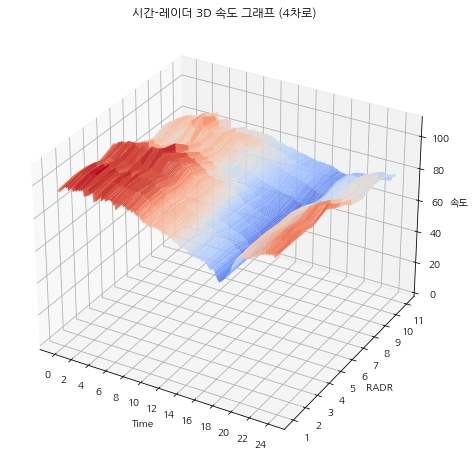

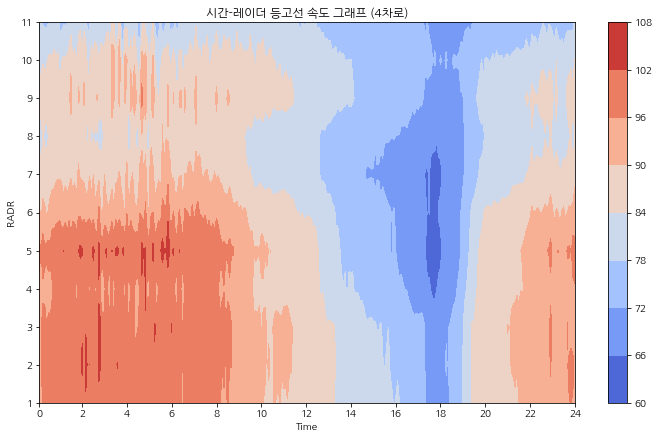

In [53]:
create_3D_Graph(up_data_v1, 4, "속도")

## 사고아닌 데이터 뽑아내기

### 사고아닌 데이터 히트맵 생성

KeyboardInterrupt: 

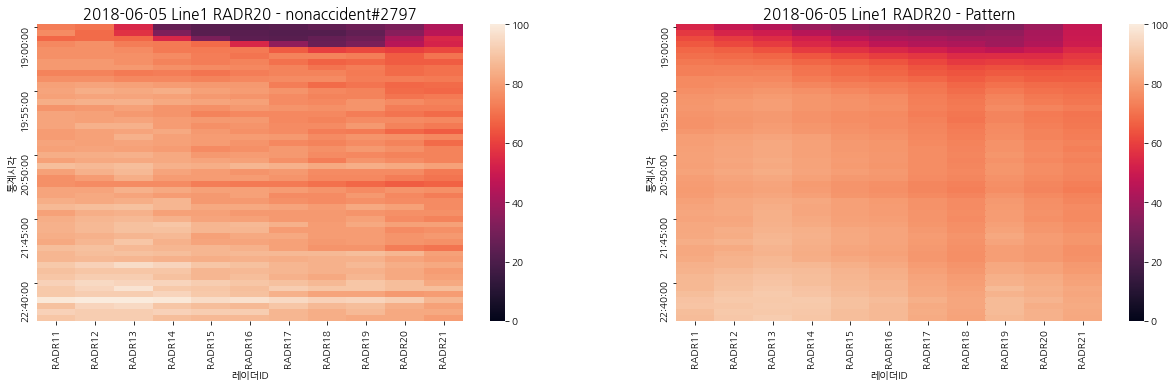

In [5]:
create_nonaccident_heatmap(up_data_v1, "속도")
create_nonaccident_heatmap(down_data_v1, "속도")

### 사고아닌 리스트 생성(차이값 리스트)

In [11]:
upNonAccList = create_nonaccident_list(up_data_v1, "속도")
downNonAccList = create_nonaccident_list(down_data_v1, "속도")

<Figure size 1512x864 with 0 Axes>

<Figure size 1512x864 with 0 Axes>

In [17]:
for i in range(0, 612, 12):
    del downNonAccList[i]
downNonAccList = ((downNonAccList.T).reset_index(drop=True)).T

nonAccList = pd.concat([upNonAccList, downNonAccList], axis = 0)

In [18]:
nonAccList.to_csv(path_AL + "nonAccList.csv", header=False)

### 사고아닌 리스트 생성(사고아닌 + 패턴데이터)

In [5]:
UpNonAccident, UpPattern = create_nonaccident_pattern_list(up_data_v1, "속도")
DownNonAccident, DownPattern = create_nonaccident_pattern_list(down_data_v1, "속도")

<Figure size 1512x864 with 0 Axes>

<Figure size 1512x864 with 0 Axes>

In [6]:
for i in range(0, 612, 12):
    del DownNonAccident[i]
DownNonAccident = ((DownNonAccident.T).reset_index(drop=True)).T

NonAccList_accident = pd.concat([UpNonAccident, DownNonAccident], axis = 0)

for i in range(0, 612, 12):
    del DownPattern[i]
DownPattern = ((DownPattern.T).reset_index(drop=True)).T

NonAccList_pattern = pd.concat([UpPattern, DownPattern], axis = 0)

In [7]:
NonAccList_accident.to_csv(path_AL + "NonAccList_accident.csv", header=False)
NonAccList_pattern.to_csv(path_AL + "NonAccList_pattern.csv", header=False)

## 요일별 라인별 패턴데이터

In [5]:
data = to_pivot_mean_data(up_data_v1, "속도")

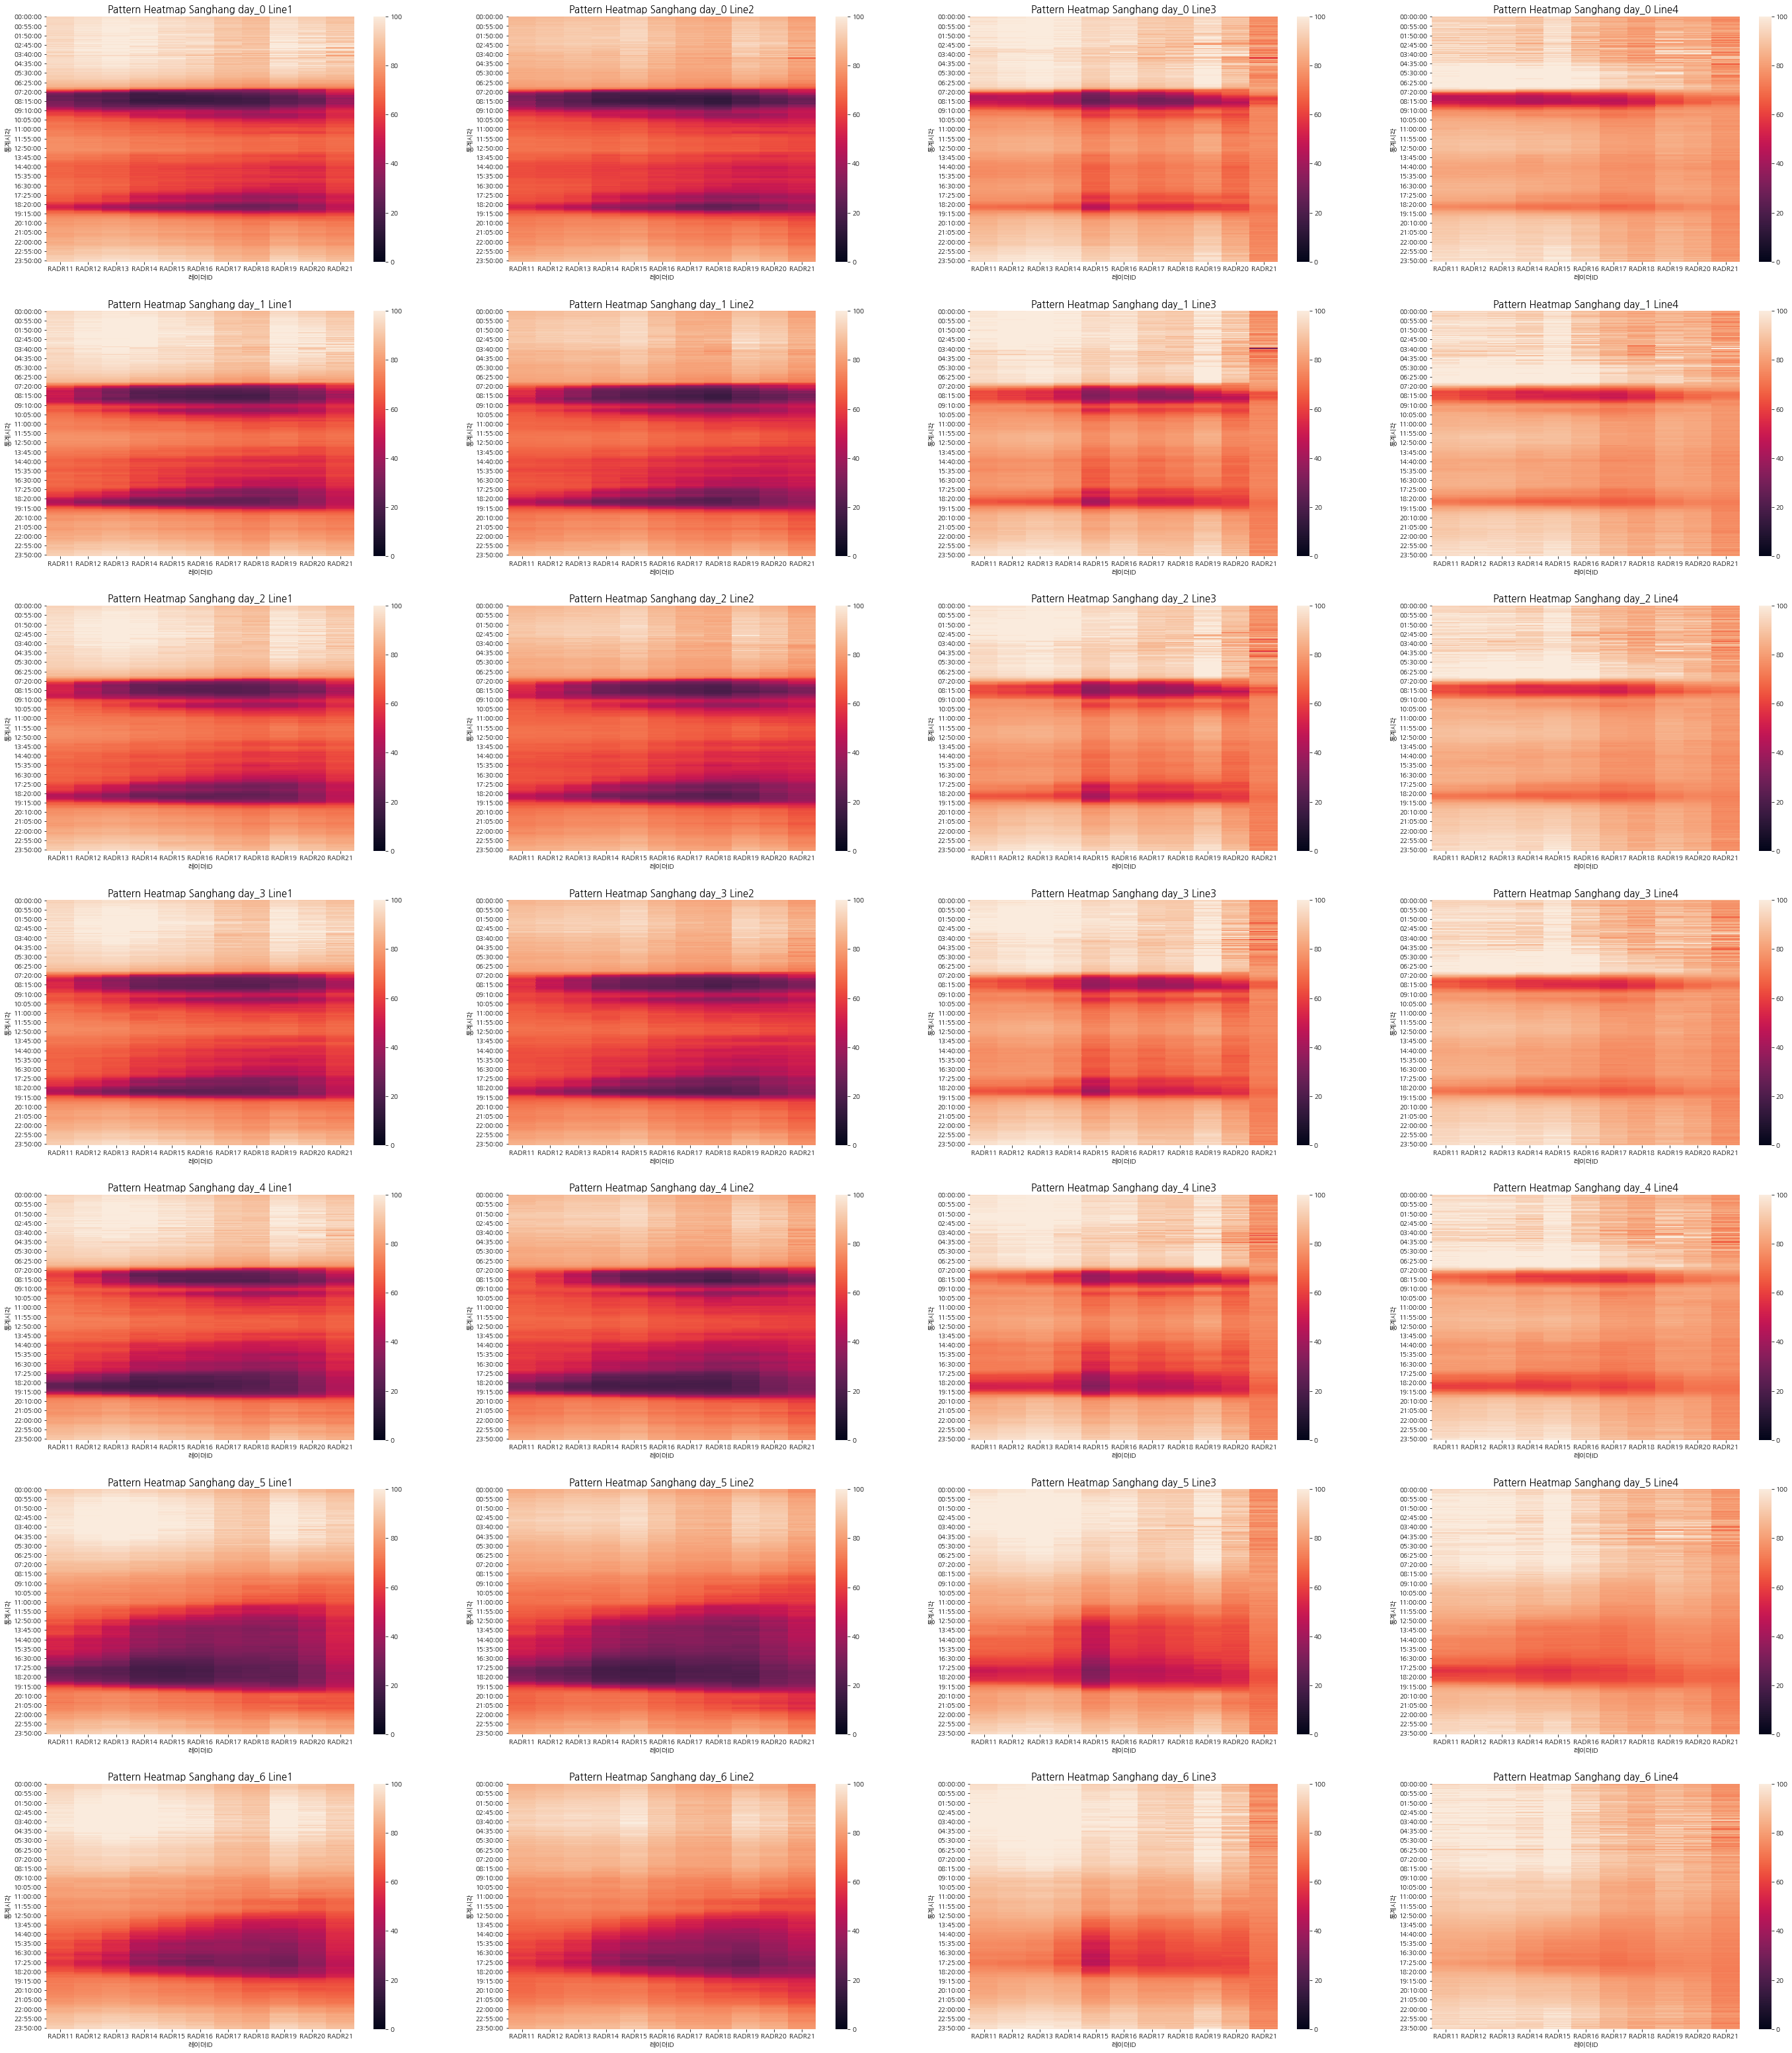

In [19]:
plt.rcParams['figure.figsize'] = [12, 8]
fig = plt.figure(figsize=(48, 56))
gs = gridspec.GridSpec(7, 4)
picNum = 0
for i in range(7):
    for j in range(1,5):
        plt.subplot(gs[picNum])
        sns.heatmap(data[i][j], yticklabels = 11, vmin=0, vmax=100)
        plt.title("Pattern Heatmap Sanghang day_{} Line{}".format(i, j), fontsize=15)
        picNum += 1
fig.savefig("../9.data/0.work_data/2.heatmap/2.day/" + "Pattern Heatmap Sanghang.jpg", dpi=400)


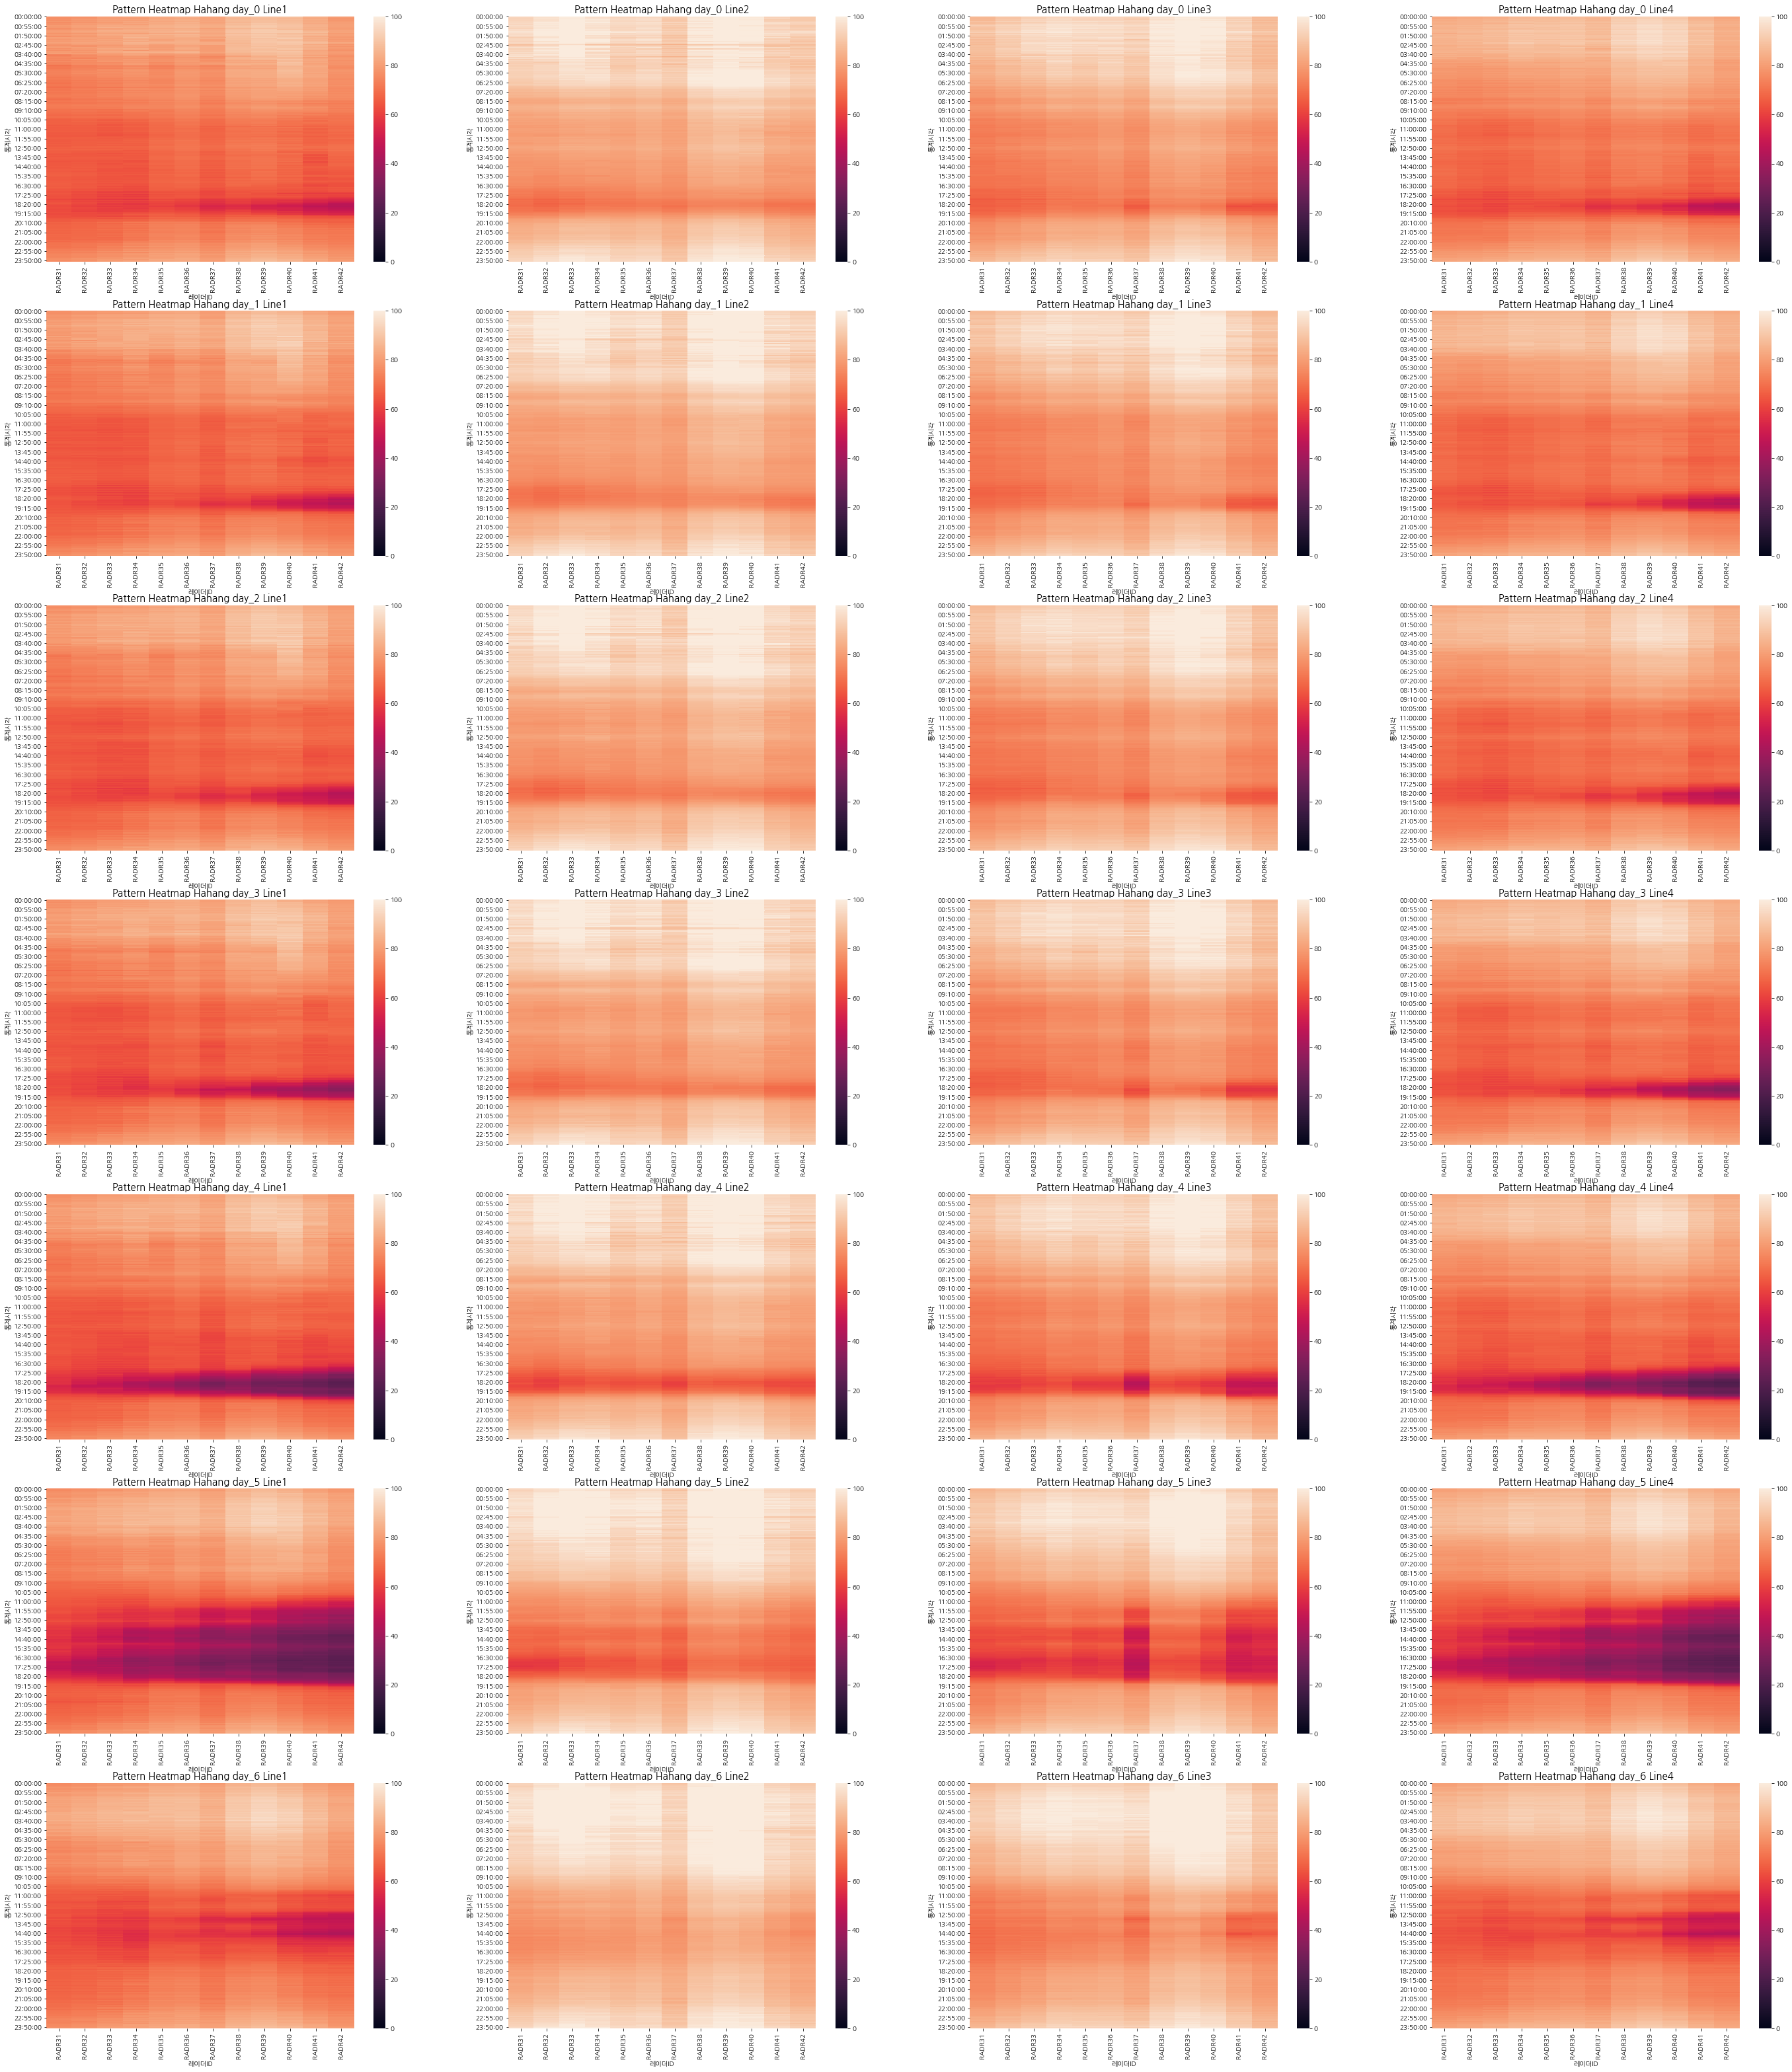

In [20]:
data = to_pivot_mean_data(down_data_v1, "속도")

plt.rcParams['figure.figsize'] = [12, 8]
fig = plt.figure(figsize=(48, 56))
gs = gridspec.GridSpec(7, 4)
picNum = 0
for i in range(7):
    for j in range(1,5):
        plt.subplot(gs[picNum])
        sns.heatmap(data[i][j], yticklabels = 11, vmin=0, vmax=100)
        plt.title("Pattern Heatmap Hahang day_{} Line{}".format(i, j), fontsize=15)
        picNum += 1
fig.savefig("../9.data/0.work_data/2.heatmap/2.day/" + "Pattern Heatmap Hahang.jpg", dpi=400)
